# <center>Assignment 2 LSTM - Fixed Window Size Loop with Adjusted-Seasonality Data

In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [78]:
# Basic Time Series Setting
import statsmodels.api as smapi
import statsmodels.tsa.api as smt

In [79]:
# RNN Package Setting
import time
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers

np.random.seed(1)

## Data Preparation

In [80]:
data=pd.read_csv('internet_retail_sales.csv',parse_dates=[0], index_col=0)
sales=data.values

### First Order Difference

In [81]:
sales_diff=pd.Series.diff(data)
sales_diff=sales_diff.dropna().values
# sales_diff

### Seosonal Decomposition

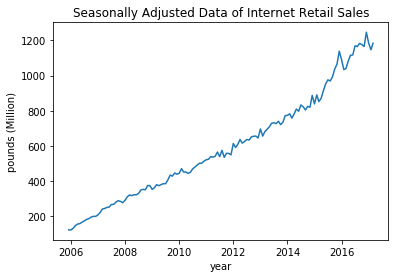

In [93]:
fig=plt.figure()
date=pd.date_range(start='11/10/2005',end='03/01/2017',freq='MS')
plt.plot(date,sales_trend[:-1])
plt.xlabel('year')
plt.ylabel('pounds (Million)')
plt.title('Seasonally Adjusted Data of Internet Retail Sales')
plt.show()
fig.savefig('seasonallyadj.png',dpi=1000)

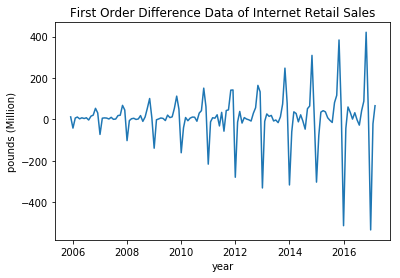

In [91]:
fig=plt.figure()
date=pd.date_range(start='11/10/2005',end='03/01/2017',freq='MS')
plt.plot(date,sales_diff)
plt.xlabel('year')
plt.ylabel('pounds (Million)')
plt.title('First Order Difference Data of Internet Retail Sales')
plt.show()
fig.savefig('1stord.png',dpi=1000)

In [85]:
decomp_obj = smapi.tsa.seasonal_decompose(data['Sales'],model='multiplicative')
# decomp_obj.plot()
sales_sea=decomp_obj.seasonal
# sales_trend=sales/sales_sea
sales_trend=np.divide(np.array(sales),pd.DataFrame(sales_sea).values)
sales_season=pd.DataFrame(sales_sea).values
seasonality=sales_season[-12:]

In [8]:
len(seasonality)

12

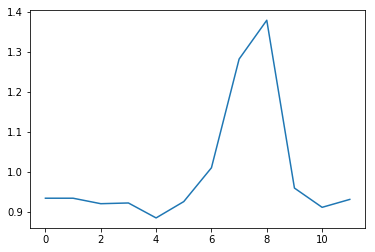

In [9]:
plt.figure()
plt.plot(seasonality)
plt.show()

### Standardisation - Trend Standardisation

In [17]:
# Standardisation
scaler = StandardScaler()
trend_scaled=scaler.fit_transform(sales_trend)

# Std & Mean Calculation
trend_std=np.std(sales_trend)
trend_mean=np.mean(sales_trend)

print(trend_std)
print(trend_mean)

304.28948500218485
597.4474138728763


## RNN-Fixed Window Size Model Fitting

### Trend Model Fitting

In [34]:
# Model Fitting
epochs=50
repeats=10

neurons_min=1
neurons_max=2

window_min=1
window_max=2

step=1

# train_loss=np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))
# cv_loss=np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))
# test_loss=[np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))]
train_loss=[]
train_loss_res=[]

cv_loss=[]
cv_loss_res=[]

test_loss_trend=[]
test_loss_multi=[]

for w in range(window_min,window_max):
       
    time_window=w
    
    Xall, yall=[],[]
    for i in range(time_window, len(trend_scaled)):
        Xall.append(trend_scaled[i-time_window:i,0])
        yall.append(trend_scaled[i,0])     
    Xall=np.array(Xall)
    yall=np.array(yall)
    
    # Real Train Test Split
    test_size=12
    Xtrain, Xtest=Xall[0:-test_size], Xall[-test_size:]
    ytrain, ytest=yall[0:-test_size], yall[-test_size:]
    # Unscaled Data Preparation for Evaluation
    # Trend
    y_train_raw=sales_trend[0:-test_size]
    y_test_raw=sales_trend[-test_size:]
    # Trend+Seasonality
    y_train_raw_multi=sales[0:-test_size]
    y_test_raw_multi=sales[-test_size:]    

    # Validation Train Test Split
    Xtrain_pse, Xtest_pse=Xtrain[0:-test_size], Xtrain[-test_size:]
    ytrain_pse, ytest_pse=ytrain[0:-test_size], ytrain[-test_size:]
    # Unscaled Data Preparation for Evaluation
    # Trend
    y_train_pse_raw=y_train_raw[0:-test_size]
    y_test_pse_raw=y_train_raw[-test_size:]
    # Trend+Seasonality
    y_train_pse_raw_multi=y_train_raw_multi[0:-test_size]
    y_test_pse_raw_multi=y_train_raw_multi[-test_size:]    

    # Real Train Test Split Reshape 
    Xtrain, Xtest=Xtrain.reshape(Xtrain.shape[0], time_window, 1), Xtest.reshape(Xtest.shape[0], time_window, 1)
    # Validation Train Test Split Reshape
    Xtrain_pse, Xtest_pse=Xtrain_pse.reshape(Xtrain_pse.shape[0], time_window, 1), Xtest_pse.reshape(Xtest_pse.shape[0], time_window, 1)


    for n in range(neurons_min,neurons_max,step):
    #         fig=plt.figure()  
        rmse_t_trend=[]
        rmse_t_multi=[]
        for j in range(repeats):

            model=Sequential()
            model.add(LSTM(n,input_shape = (time_window,1), batch_size=1,stateful=True))
            model.add(Dropout(0.2))
            model.add(Dense(1,activation='linear'))
            #     model.add(Dense(1))

            # compile model for use
            start=time.time()
            model.compile(loss="mse", optimizer="rmsprop")
            print("Compilation Time : ", time.time() - start)

            train_loss_t=[]
            cv_loss_t=[]   
            for i in range(epochs):
                history=model.fit(Xtrain_pse,ytrain_pse, epochs=1, batch_size=1, verbose=2,validation_split=0.1,shuffle=False)
                train_loss_t.append(history.history['loss'])
                cv_loss_t.append(history.history['val_loss'])
                model.reset_states()

            # Loss Calculation  
            # Test RMSE - For my own happiness
            test_predict_pse = model.predict(Xtest_pse,batch_size=1)
            test_predict_pse=scaler.inverse_transform(test_predict_pse)  
            test_predict_pse_multi=np.multiply(np.array(test_predict_pse),seasonality)
            # Trend RMSE
            rmse_t_trend.append(math.sqrt(mean_squared_error(y_test_pse_raw,test_predict_pse)))
            # Trend+Seasonality RMSE
            rmse_t_multi.append(math.sqrt(mean_squared_error(y_test_pse_raw_multi,test_predict_pse_multi)))
                
            # cross validation loss
            cv_loss.append(np.array(cv_loss_t))
            cv_loss_res.append(np.array(cv_loss_t)*trend_std)
            # training loss
            train_loss.append(np.array(train_loss_t))            
            train_loss_res.append(np.array(train_loss_t)*trend_std)
        
        # TREND            
        rmse_t_trend.append(np.mean(rmse_t_trend)) # calculate mean and std of Trend RMSE
        rmse_t_trend.append(np.std(rmse_t_trend))
        test_loss_trend.append(rmse_t_trend) # append mean and std of rmse
        # TREND+SEASONALITY RMSE
        rmse_t_multi.append(np.mean(rmse_t_multi)) # calculate mean and std of Trend RMSE
        rmse_t_multi.append(np.std(rmse_t_multi))
        test_loss_multi.append(rmse_t_multi) # append mean and std of rmse        
        
# plt.plot(train_loss,color='blue')
# plt.plot(cv_loss,color='orange')
    
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# # # plt.legend(['train', 'validation'], loc='upper right')
# plt.show()
# fig.savefig('epochs_tuning.png',dpi=1000)

Compilation Time :  0.015996217727661133
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.5936 - val_loss: 0.7193
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.4925 - val_loss: 0.7133
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.3965 - val_loss: 0.6702
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.3089 - val_loss: 0.6027
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.2812 - val_loss: 0.5186
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.2466 - val_loss: 0.4468
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1960 - val_loss: 0.3790
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.2208 - val_loss: 0.3266
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1365 - val_loss: 0.2780
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1997 - val_loss: 0.2616
Train on 

 - 0s - loss: 0.1047 - val_loss: 0.2514
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1019 - val_loss: 0.2612
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1486 - val_loss: 0.2615
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1178 - val_loss: 0.2572
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0753 - val_loss: 0.2560
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0778 - val_loss: 0.2556
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1176 - val_loss: 0.2511
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1206 - val_loss: 0.2600
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0672 - val_loss: 0.2543
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1082 - val_loss: 0.2586
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1121 - val_loss: 0.2643
Train on 1

Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1511 - val_loss: 0.3550
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1034 - val_loss: 0.3556
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0810 - val_loss: 0.3532
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0880 - val_loss: 0.3436
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0886 - val_loss: 0.3365
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1323 - val_loss: 0.3386
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1377 - val_loss: 0.3450
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0680 - val_loss: 0.3335
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0994 - val_loss: 0.3360
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0882 - val_loss: 0.3344
Train on 100 samples, validate on 12 samples
Epoch

 - 0s - loss: 0.2285 - val_loss: 0.1882
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.2408 - val_loss: 0.1986
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.2176 - val_loss: 0.2053
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.2122 - val_loss: 0.2117
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1867 - val_loss: 0.2154
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1784 - val_loss: 0.2310
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1994 - val_loss: 0.2388
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1627 - val_loss: 0.2530
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1718 - val_loss: 0.2622
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1725 - val_loss: 0.2781
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1374 - val_loss: 0.2720
Train on 1

 - 0s - loss: 0.0884 - val_loss: 0.3139
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0967 - val_loss: 0.3097
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0868 - val_loss: 0.2995
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1034 - val_loss: 0.2985
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1258 - val_loss: 0.3093
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1027 - val_loss: 0.3131
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1106 - val_loss: 0.3099
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0834 - val_loss: 0.3074
Compilation Time :  0.012097358703613281
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 1.3815 - val_loss: 1.0051
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 1.1791 - val_loss: 1.0042
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - l

Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1378 - val_loss: 0.2165
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1282 - val_loss: 0.2211
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1416 - val_loss: 0.2214
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1165 - val_loss: 0.2191
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0850 - val_loss: 0.2222
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0955 - val_loss: 0.2197
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0901 - val_loss: 0.2190
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.1474 - val_loss: 0.2240
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0940 - val_loss: 0.2185
Train on 100 samples, validate on 12 samples
Epoch 1/1
 - 0s - loss: 0.0782 - val_loss: 0.2149
Train on 100 samples, validate on 12 samples
Epoch

In [35]:
print(test_loss_trend)
print(test_loss_multi)

[[379.4371896132396, 354.7727023703415, 355.8266940388991, 368.94741761441526, 338.0632513039039, 335.2454857022231, 408.32914022518594, 440.15040687514124, 319.96004221979086, 375.21466311116643, 367.5946993074307, 32.49376415803359]]
[[395.42286444929135, 368.9163174674954, 373.5456701559647, 384.7826330347811, 352.4010659435494, 349.98091028484066, 429.92633120847694, 460.88569782984774, 333.7600315831999, 391.08357687956743, 384.07050988370145, 34.66530376592377]]


In [27]:
# test_loss_trend_sum=[]
# test_loss_multi_sum=[]

test_loss_trend_sum.append(np.array(test_loss_trend))
test_loss_multi_sum.append(np.array(test_loss_multi))

In [28]:
print(test_loss_multi_sum)

[array([[300.95421689, 274.75331535, 309.48490778, 358.07170743,
        245.3537022 , 297.72356993,  34.30476033]]), array([[301.16785514, 437.71471927, 281.89169482, 392.27004854,
        377.42112426, 358.0930884 ,  53.11681505]]), array([[301.16785514, 437.71471927, 281.89169482, 392.27004854,
        377.42112426, 358.0930884 ,  53.11681505]])]


In [46]:
cv_loss

[array([[0.28190855]]), array([[0.65600012]])]

In [47]:
cv_loss_res

[array([[85.78180792]]), array([[199.61393983]])]

In [48]:
train_loss_res

[array([[36.64369147]]), array([[124.20996991]])]

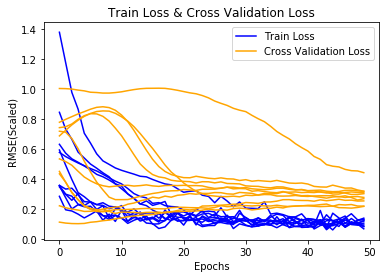

In [36]:
# Cross Validation Visualization
fig=plt.figure()
line1=plt.plot(np.array(train_loss)[0,:],color='blue',label="Train Loss")
plt.plot(np.array(train_loss)[1,:],color='blue')
plt.plot(np.array(train_loss)[2,:],color='blue')
plt.plot(np.array(train_loss)[3,:],color='blue')
plt.plot(np.array(train_loss)[4,:],color='blue')
plt.plot(np.array(train_loss)[5,:],color='blue')
plt.plot(np.array(train_loss)[6,:],color='blue')
plt.plot(np.array(train_loss)[7,:],color='blue')
plt.plot(np.array(train_loss)[8,:],color='blue')
plt.plot(np.array(train_loss)[9,:],color='blue')



line2=plt.plot(np.array(cv_loss)[0,:],color='orange',label= "Cross Validation Loss")
plt.plot(np.array(cv_loss)[1,:],color='orange')
plt.plot(np.array(cv_loss)[2,:],color='orange')
plt.plot(np.array(cv_loss)[3,:],color='orange')
plt.plot(np.array(cv_loss)[4,:],color='orange')
plt.plot(np.array(cv_loss)[5,:],color='orange')
plt.plot(np.array(cv_loss)[6,:],color='orange')
plt.plot(np.array(cv_loss)[7,:],color='orange')
plt.plot(np.array(cv_loss)[8,:],color='orange')
plt.plot(np.array(cv_loss)[9,:],color='orange')


plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE(Scaled)')
plt.title('Train Loss & Cross Validation Loss')
plt.show()
fig.savefig('loss_output.png',dpi=1000)

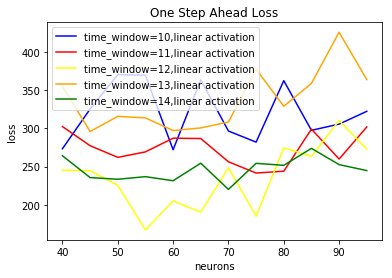

In [268]:
fig=plt.figure()
plt.plot(np.arange(40,100,5),test_loss.iloc[0,:],label='time_window=10,linear activation',color='blue')
plt.plot(np.arange(40,100,5),test_loss.iloc[1,:],label='time_window=11,linear activation',color='red')
plt.plot(np.arange(40,100,5),test_loss.iloc[2,:],label='time_window=12,linear activation',color='yellow')
plt.plot(np.arange(40,100,5),test_loss.iloc[3,:],label='time_window=13,linear activation',color='orange')
plt.plot(np.arange(40,100,5),test_loss.iloc[4,:],label='time_window=14,linear activation',color='green')
plt.legend()
plt.xlabel('neurons')
plt.ylabel('loss')
plt.title('One Step Ahead Loss')
plt.show()
fig.savefig('loss_output.png',dpi=1000)

In [269]:
test_loss.to_excel('Loss_T10-14_N40-100.xlsx')

In [200]:
# Predict
train_predict = model.predict(Xtrain,batch_size=1)
test_predict = model.predict(Xtest,batch_size=1)

# Inverse Prediction
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

## Training Score

In [201]:
# epochs_summary=[]
# neurons_summary=[]
# rmse_summary=[]
# mae_summary=[]

In [202]:
rmse=math.sqrt(mean_squared_error(y_test_raw,test_predict))
mae=mean_absolute_error(y_test_raw,test_predict)

In [203]:
epochs_summary.append(epochs)
neurons_summary.append(neurons)
rmse_summary.append(rmse)
mae_summary.append(mae)

print(epochs_summary)
print(neurons_summary)
print(rmse_summary)
print(mae_summary)

[300, 300, 300, 300, 300, 300, 300]
[5, 10, 50, 100, 150, 125, 113]
[318.7349936417306, 230.30975251899886, 208.24286191876573, 134.40613515925975, 299.2879239417023, 338.1812868338608, 225.34691825042538]
[260.30489908854173, 126.15896402994788, 146.3288401285807, 111.27141418457029, 243.473257446289, 287.5988016764323, 174.387559000651]


## Diagnostic Plot

ZeroDivisionError: integer division or modulo by zero

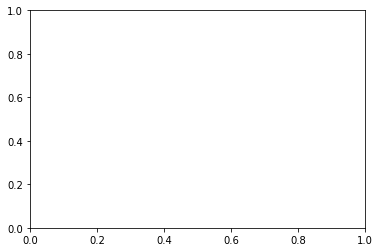

In [101]:
fig=plt.figure()
plt.plot(train_loss_summary)
plt.plot(cv_loss_summary)
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
fig.savefig('epochs_tuning.png',dpi=1000)

In [102]:
train_loss_summary

""


In [60]:
t3_data=pd.read_csv('test_loss.csv')
t3_data.head(10)

,N1,N2,N3,N4,N5
0,73.578849,72.351499,74.498024,82.176711,85.701434
1,71.041034,73.539004,73.779110,83.397234,76.726428
2,72.591598,71.803879,74.044446,76.516884,95.393377
3,72.831768,75.361877,73.358326,78.431738,81.470941
4,72.012841,74.500162,76.423331,82.055410,83.312501
5,71.307000,73.536701,78.577280,78.280035,87.553942
6,71.437664,73.817047,74.344667,81.467094,84.033081
7,70.606481,72.170360,74.762092,89.983912,85.511858
8,71.663357,77.840085,70.797480,88.916574,79.774779
9,70.509277,72.201103,72.613115,76.722812,85.588556


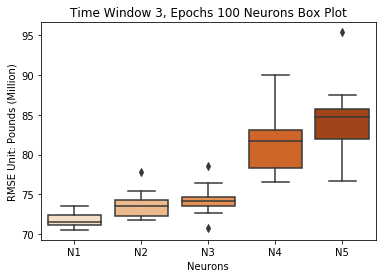

In [75]:
ax=sns.boxplot(data=t3_data, palette='Oranges')
ax.set_title('Time Window 3, Epochs 100 Neurons Box Plot')
ax.set_ylabel('RMSE Unit: Pounds (Million)')
ax.set_xlabel('Neurons')
ax.figure.savefig('T3NeuronsBoxPlot.png',dpi=1000)